# Advance Machine Learning - Assignment 2
#### Villa Giacomo 807462

## Importing Libraries

In [2]:
import pickle 

import numpy as np

import keras 
from keras import backend as K
from keras.utils import np_utils
from keras.models import Sequential, Model
from keras.layers import Dense, Activation, Dropout, Input
from keras.utils import plot_model
from keras.wrappers.scikit_learn import KerasClassifier
from keras.callbacks import EarlyStopping, ModelCheckpoint

from collections import Counter

from matplotlib import pyplot as plt
import matplotlib as mpl
%matplotlib inline

from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_validate, cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.manifold import TSNE

from statistics import mean 

import pandas as pd

import seaborn as sns
import operator

## Functions

In [2]:
def load_data():
    
    x_train = pickle.load(open("x_train.obj", "rb"))
    
    x_test = pickle.load(open("x_test.obj", "rb"))
    
    y_train = pickle.load(open("y_train.obj", "rb"))
    
    return x_train, y_train, x_test

def preprocessing_data(x_train, y_train_noHot, x_test):
    
    new_train = y_train_noHot

    x_train = x_train.reshape(14000, 784) 
    x_test = x_test.reshape(8800, 784)
    x_train = x_train.astype("float32")
    x_test = x_test.astype("float32")
    
    x_train /= 255.
    x_test /= 255.
    
    for index in range(0, len(new_train)):
        new_train[index] -= 16
    
    new_train = np_utils.to_categorical(new_train, 11)
    
    return x_train, new_train, x_test

def define_model(opt, input_size):
    
    model = Sequential()
    model.add(Dense(512, input_shape = (input_size,), activation='relu'))
    model.add(Dropout(0.4, noise_shape=None, seed=None))
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.4, noise_shape=None, seed=None))
    model.add(Dense(y_train_oneHot.shape[1]))
    model.add(Activation('softmax'))
    model.compile(optimizer = opt, loss = 'categorical_crossentropy', metrics = ['accuracy'])
    # model.summary()

    return model
    
def display_image(image):
    
    fig = plt.figure()
    ax = fig.add_subplot(1,1,1)
    imgplot = ax.imshow(image, cmap=mpl.cm.Greys)
    imgplot.set_interpolation('nearest')
    ax.xaxis.set_ticks_position('top')
    ax.yaxis.set_ticks_position('left')
    plt.show()
    
    
def map_fields(init_dict, map_dict, res_dict=None):

    res_dict = res_dict or {}
    for k, v in init_dict.items():

        if isinstance(v, dict):
            v = map_fields(v, map_dict[k])
        elif k in map_dict.keys():
            k = str(map_dict[k])
        res_dict[k] = v
    return res_dict

    
def get_train_letters(letters):
    
    letter, counts = np.unique(letters, return_counts=True)
    distribution = dict(zip(letter, counts))
    colors = ['#ff9999','#66b3ff','#99ff99','#ffcc99', '#99f3ff', '#ff99f5', '#ffb999', '#fff199', '#9b99ff',
             '#abb57b', '#0d6775']
    
    new_key = {16: 'P', 17: 'Q', 18: 'R', 19: 'S', 20: 'T', 21: 'U', 22: 'V', 23: 'W',
              24: 'X', 25: 'Y', 26: 'Z'}
    
    letter_distribution = map_fields(distribution, new_key)
    
    label = list(letter_distribution.keys())
    values = list(letter_distribution.values())
    
    
    fig1, ax1 = plt.subplots()
    
    ax1.pie( values, labels = label , autopct='%1.1f%%', shadow=True, startangle=90, colors=colors)
    ax1.axis('equal')
    plt.show()
    
def plotConfusionMatrix(y_true, y_pred, classes, normalize, title, cmap = plt.cm.get_cmap("Blues")):
    
    cm = confusion_matrix(y_true, y_pred)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    # print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap= cmap)
    ax.figure.colorbar(im, ax=ax)

    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),

           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()

    plt.show(ax)
    
def get_performance(y, y_predict):
      
    plotConfusionMatrix(y, y_predict, ['P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z'],
                        False, "Confusion Matrix fold: " + str(fold + 1), cmap= plt.cm.get_cmap('Blues'))
    
    precision = [classification_report(y, y_predict, output_dict = True)['16']['precision'], 
                       classification_report(y, y_predict, output_dict = True)['17']['precision'],
                       classification_report(y, y_predict, output_dict = True)['18']['precision'],
                       classification_report(y, y_predict, output_dict = True)['19']['precision'],
                       classification_report(y, y_predict, output_dict = True)['20']['precision'],
                       classification_report(y, y_predict, output_dict = True)['21']['precision'],
                       classification_report(y, y_predict, output_dict = True)['22']['precision'],
                       classification_report(y, y_predict, output_dict = True)['23']['precision'],
                       classification_report(y, y_predict, output_dict = True)['24']['precision'],
                       classification_report(y, y_predict, output_dict = True)['25']['precision'],
                       classification_report(y, y_predict, output_dict = True)['26']['precision']]
    
    recall = [classification_report(y, y_predict, output_dict = True)['16']['recall'], 
                       classification_report(y, y_predict, output_dict = True)['17']['recall'],
                       classification_report(y, y_predict, output_dict = True)['18']['recall'],
                       classification_report(y, y_predict, output_dict = True)['19']['recall'],
                       classification_report(y, y_predict, output_dict = True)['20']['recall'],
                       classification_report(y, y_predict, output_dict = True)['21']['recall'],
                       classification_report(y, y_predict, output_dict = True)['22']['recall'],
                       classification_report(y, y_predict, output_dict = True)['23']['recall'],
                       classification_report(y, y_predict, output_dict = True)['24']['recall'],
                       classification_report(y, y_predict, output_dict = True)['25']['recall'],
                       classification_report(y, y_predict, output_dict = True)['26']['recall']]
    
    
    f_score_avg = classification_report(y, y_predict, output_dict = True)['weighted avg']['f1-score']
    
    return precision, recall, f_score_avg

def compute_precision_recall_for_class(precision, recall, class_id):
    
    class_precision = [0]*10
    class_recall = [0]*10
    
    for i in range(0, len(precision)):
        class_precision[i] = precision[i][class_id]
        class_recall[i] = recall[i][class_id]
        
    return class_precision, class_recall

def print_class_performance(precision, recall):
    
    classes = ('P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z')   
    
    for i in range(0, 11):
        
        class_precision, class_recall = compute_precision_recall_for_class(precision, recall, i)
        
        print("PRECISION MEAN FOR CLASS "+ classes[i]+": " , end = " ")
        print(round(mean(class_precision), 3))
        print("RECALL MEAN FOR CLASS "+ classes[i]+": " , end = " ")
        print(round(mean(class_recall), 3))
        print("")
        
def numbers_to_character(number): 
    
    switcher = { 
        16: "P", 
        17: "Q", 
        18: "R", 
        19: "S", 
        20: "T", 
        21: "U", 
        22: "V", 
        23: "W", 
        24: "X", 
        25: "Y", 
        26: "Z", 
    } 
    return switcher.get(number, "nothing") 

def plot_history(network_history, index):
    
    plt.figure(figsize=(15,5)) 
    plt.xlabel('Epochs')
    plt.ylabel(index)
    plt.plot(network_history.history[index])
    plt.plot(network_history.history["val_"+index])
    plt.legend(['Training', 'Validation'], loc='best')

    plt.show()

## Loading Data

X TRAIN TYPE <class 'numpy.ndarray'>
~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~
X TRAIN SHAPE:  (14000, 28, 28)
X TEST SHAPE:  (8800, 28, 28)
Y TRAIN SHAPE:  (14000,)
~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~
FIRST 10 Y TRAIN:  [18 21 17 21 23 26 18 22 21 24]
~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~
MOST COMMON VALUE IN Y TRAIN:  18
TIMES:  1346
SHOW LETTER AND ALPHABET POSITION


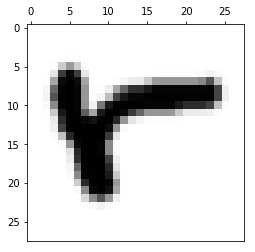

18


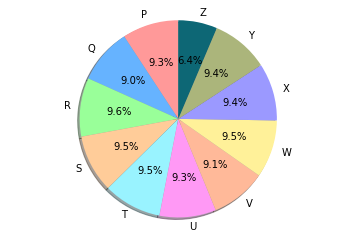

~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~
X TRAIN SHAPE:  (14000, 784)
X TEST SHAPE:  (8800, 784)
Y TRAIN ONE HOT:  (14000, 11)
Y TRAIN SHAPE:  (14000,)
~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~


In [3]:
x_train, y_train, x_test_norm = load_data()

most_common, num_most_common = Counter(y_train).most_common(1)[0]

print("X TRAIN TYPE", type(x_train))
print("~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~")
print("X TRAIN SHAPE: ", x_train.shape)
print("X TEST SHAPE: ", x_test_norm.shape)
print("Y TRAIN SHAPE: ", y_train.shape)
print("~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~")
print("FIRST 10 Y TRAIN: ", y_train[0:10])
print("~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~")
print("MOST COMMON VALUE IN Y TRAIN: ", most_common)
print("TIMES: ", num_most_common)

print("SHOW LETTER AND ALPHABET POSITION")
display_image(x_train[6])
print(y_train[6])
        
get_train_letters(y_train)

x_train, y_train_oneHot, x_test = preprocessing_data(x_train, y_train, x_test_norm)

print("~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~")
print("X TRAIN SHAPE: ", x_train.shape)
print("X TEST SHAPE: ", x_test.shape)
print("Y TRAIN ONE HOT: ", y_train_oneHot.shape)
print("Y TRAIN SHAPE: ", y_train.shape)
print("~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~")

y_train += 16

# Autoecoder
In this section I build, train and test an autoencoder; changed the value of *dim1* and *dim2* is possible done differents tests about compression. 

In [38]:
encoding_dim = 128
encoding_dim_2 = 64

input_img = Input(shape=(784,))

encoded = Dense(encoding_dim, activation = "relu")(input_img)
encoded = Dense(encoding_dim_2, activation = "relu")(encoded)

decoded = Dense(encoding_dim, activation = "relu")(encoded)
decoded = Dense(784, activation = "sigmoid")(decoded)

autoencoder = Model(input_img, decoded)
encoder = Model(input_img, encoded)


encoded_input = Input(shape = (encoding_dim_2,))
decode_layer_1 = autoencoder.layers[-2](encoded_input)
decode_layer_2 = autoencoder.layers[-1](decode_layer_1)

decoder = Model(encoded_input, decode_layer_2)

autoencoder.compile(optimizer='adam', loss='binary_crossentropy')
autoencoder.summary()

Model: "model_22"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_15 (InputLayer)        (None, 784)               0         
_________________________________________________________________
dense_29 (Dense)             (None, 128)               100480    
_________________________________________________________________
dense_30 (Dense)             (None, 64)                8256      
_________________________________________________________________
dense_31 (Dense)             (None, 128)               8320      
_________________________________________________________________
dense_32 (Dense)             (None, 784)               101136    
Total params: 218,192
Trainable params: 218,192
Non-trainable params: 0
_________________________________________________________________


In [39]:
x_train_enco, x_val = train_test_split(x_train, test_size = 0.2)

In [40]:
es = EarlyStopping(monitor='val_loss', patience = 10, restore_best_weights = True)
history_autoencoder = autoencoder.fit(x_train_enco, x_train_enco, epochs=200, batch_size=256, 
                        shuffle=True, validation_data=(x_val, x_val), callbacks = [es])

Train on 11200 samples, validate on 2800 samples
Epoch 1/200
11200/11200 [==============================] - 1s 48us/step - loss: 0.4592 - val_loss: 0.3441
Epoch 2/200
11200/11200 [==============================] - 0s 41us/step - loss: 0.3105 - val_loss: 0.2820
Epoch 3/200
11200/11200 [==============================] - 0s 41us/step - loss: 0.2647 - val_loss: 0.2452
Epoch 4/200
11200/11200 [==============================] - 0s 38us/step - loss: 0.2321 - val_loss: 0.2177
Epoch 5/200
11200/11200 [==============================] - 0s 36us/step - loss: 0.2088 - val_loss: 0.1992
Epoch 6/200
11200/11200 [==============================] - 0s 36us/step - loss: 0.1939 - val_loss: 0.1875
Epoch 7/200
11200/11200 [==============================] - 0s 38us/step - loss: 0.1844 - val_loss: 0.1804
Epoch 8/200
11200/11200 [==============================] - 0s 36us/step - loss: 0.1782 - val_loss: 0.1752
Epoch 9/200
11200/11200 [==============================] - 0s 38us/step - loss: 0.1731 - val_loss: 0.17

11200/11200 [==============================] - 0s 36us/step - loss: 0.1252 - val_loss: 0.1270
Epoch 154/200
11200/11200 [==============================] - 0s 35us/step - loss: 0.1252 - val_loss: 0.1269
Epoch 155/200
11200/11200 [==============================] - 0s 35us/step - loss: 0.1252 - val_loss: 0.1274
Epoch 156/200
11200/11200 [==============================] - 0s 35us/step - loss: 0.1250 - val_loss: 0.1267
Epoch 157/200
11200/11200 [==============================] - 0s 35us/step - loss: 0.1249 - val_loss: 0.1267
Epoch 158/200
11200/11200 [==============================] - 0s 36us/step - loss: 0.1250 - val_loss: 0.1268
Epoch 159/200
11200/11200 [==============================] - 0s 35us/step - loss: 0.1252 - val_loss: 0.1270
Epoch 160/200
11200/11200 [==============================] - 0s 35us/step - loss: 0.1250 - val_loss: 0.1268
Epoch 161/200
11200/11200 [==============================] - 0s 35us/step - loss: 0.1248 - val_loss: 0.1265
Epoch 162/200
11200/11200 [===============

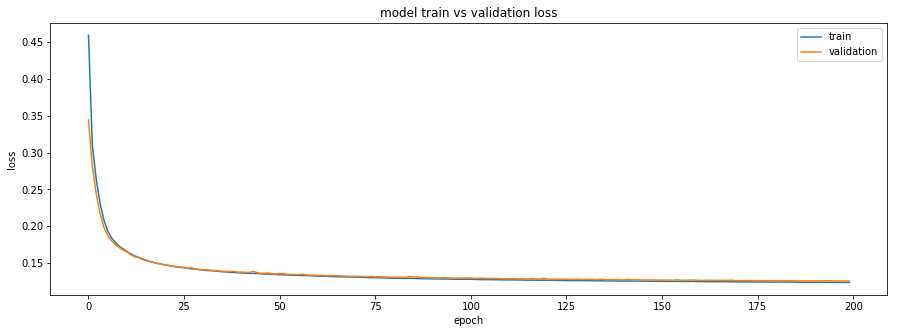

In [41]:
plt.figure(figsize=(15,5))
plt.plot(history_autoencoder.history['loss'])
plt.plot(history_autoencoder.history['val_loss'])
plt.title('model train vs validation loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')

In [42]:
encoding_dim = 128
encoding_dim_2 = 64

input_img = Input(shape=(784,))

encoded = Dense(encoding_dim, activation = "relu")(input_img)
encoded = Dense(encoding_dim_2, activation = "relu")(encoded)

decoded = Dense(encoding_dim, activation = "relu")(encoded)
decoded = Dense(784, activation = "sigmoid")(decoded)

autoencoder = Model(input_img, decoded)
encoder = Model(input_img, encoded)


encoded_input = Input(shape = (encoding_dim_2,))
decode_layer_1 = autoencoder.layers[-2](encoded_input)
decode_layer_2 = autoencoder.layers[-1](decode_layer_1)

decoder = Model(encoded_input, decode_layer_2)

autoencoder.compile(optimizer='adam', loss='binary_crossentropy')
autoencoder.summary()

Model: "model_25"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_17 (InputLayer)        (None, 784)               0         
_________________________________________________________________
dense_33 (Dense)             (None, 128)               100480    
_________________________________________________________________
dense_34 (Dense)             (None, 64)                8256      
_________________________________________________________________
dense_35 (Dense)             (None, 128)               8320      
_________________________________________________________________
dense_36 (Dense)             (None, 784)               101136    
Total params: 218,192
Trainable params: 218,192
Non-trainable params: 0
_________________________________________________________________


In [43]:
es = EarlyStopping(monitor='loss', patience = 10, restore_best_weights = True)
history_autoencoder = autoencoder.fit(x_train, x_train, epochs=200, batch_size=256, 
                        shuffle=True, callbacks = [es])

Epoch 1/200
14000/14000 [==============================] - 1s 42us/step - loss: 0.4299
Epoch 2/200
14000/14000 [==============================] - 1s 38us/step - loss: 0.2911
Epoch 3/200
14000/14000 [==============================] - 0s 33us/step - loss: 0.2415
Epoch 4/200
14000/14000 [==============================] - 0s 33us/step - loss: 0.2095
Epoch 5/200
14000/14000 [==============================] - 0s 34us/step - loss: 0.1903
Epoch 6/200
14000/14000 [==============================] - 0s 33us/step - loss: 0.1786
Epoch 7/200
14000/14000 [==============================] - 1s 37us/step - loss: 0.1715
Epoch 8/200
14000/14000 [==============================] - 0s 35us/step - loss: 0.1664
Epoch 9/200
14000/14000 [==============================] - 1s 37us/step - loss: 0.1629
Epoch 10/200
14000/14000 [==============================] - 1s 37us/step - loss: 0.1601
Epoch 11/200
14000/14000 [==============================] - 0s 33us/step - loss: 0.1576
Epoch 12/200
14000/14000 [===============

14000/14000 [==============================] - 1s 36us/step - loss: 0.1233
Epoch 187/200
14000/14000 [==============================] - 0s 35us/step - loss: 0.1233
Epoch 188/200
14000/14000 [==============================] - 0s 32us/step - loss: 0.1231
Epoch 189/200
14000/14000 [==============================] - 0s 33us/step - loss: 0.1232
Epoch 190/200
14000/14000 [==============================] - 0s 33us/step - loss: 0.1233
Epoch 191/200
14000/14000 [==============================] - 1s 37us/step - loss: 0.1231
Epoch 192/200
14000/14000 [==============================] - 0s 35us/step - loss: 0.1231
Epoch 193/200
14000/14000 [==============================] - 0s 35us/step - loss: 0.1231
Epoch 194/200
14000/14000 [==============================] - 0s 34us/step - loss: 0.1231
Epoch 195/200
14000/14000 [==============================] - 0s 35us/step - loss: 0.1231
Epoch 196/200
14000/14000 [==============================] - 1s 40us/step - loss: 0.1231
Epoch 197/200
14000/14000 [========

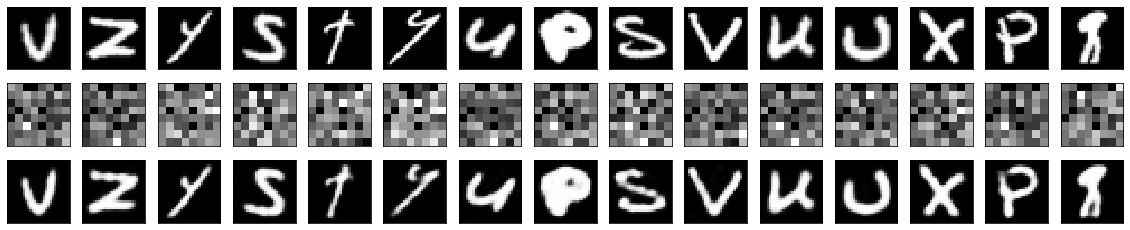

In [44]:
enc_imgs = encoder.predict(x_test)
dec_imgs = decoder.predict(enc_imgs)

n = 15 
plt.figure(figsize=(20, 4))
for i in range(n):
    
    # original
    ax = plt.subplot(3, n, i + 1)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
    # encoding images
    ax = plt.subplot(3, n, i + 1 + n)
    plt.imshow(enc_imgs[i].reshape(8, 8))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
    # reconstruction
    ax = plt.subplot(3, n, 2*n + i + 1)
    plt.imshow(dec_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

plt.show()

# Searching best optimizer for my model
In this section I perform a 10 CV with different optimizer and looking for the best accuracy result on the mean in the test fold. 

In [7]:
kfold = StratifiedKFold(n_splits=10, shuffle=True)
cvscores = []
history_cross = [None]*10
fold = 0

optimizers = {'SGD' : [], 'RMSprop' : [], 'Adagrad' : [], 'Adadelta' : [], 'Adam' : [], 'Adamax' : [], 'Nadam': []}

es = EarlyStopping(monitor='val_accuracy', patience = 10, verbose = 2, restore_best_weights = True)
for optimizer in optimizers:

    print("WITH OPTIMIZER: ", optimizer)
    for train, test in kfold.split(x_train, y_train):
        
        print("FOLD NUMBER: ", fold + 1)

        model = define_model(optimizer, x_train.shape[1])
        
        x_test_real, x_val, y_test_real, y_val = train_test_split(x_train[test], y_train_oneHot[test],
                                                                  test_size = 0.2)

        history_cross[fold] = model.fit(x_train[train],
                                        y_train_oneHot[train],
                                        epochs=200,
                                        batch_size=256,
                                        verbose = 2,
                                        validation_data=(x_val, y_val), 
                                        callbacks = [es])
        
        scores = model.evaluate(x_test_real, y_test_real, verbose = 0)

        fold += 1

        print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))
        cvscores.append(scores[1] * 100)
        print("")
    print("%.2f%% (+/- %.2f%%)" % (np.mean(cvscores), np.std(cvscores)))
    print(cvscores)
    optimizers[optimizer] = list(cvscores)
    history_cross = [None]*10
    cvscores.clear()
    fold = 0
    print("")

WITH OPTIMIZER:  SGD
FOLD NUMBER:  1
Train on 12595 samples, validate on 281 samples
Epoch 1/200
 - 1s - loss: 2.3515 - accuracy: 0.1562 - val_loss: 2.1249 - val_accuracy: 0.4555
Epoch 2/200
 - 0s - loss: 2.1036 - accuracy: 0.3001 - val_loss: 1.8879 - val_accuracy: 0.5552
Epoch 3/200
 - 0s - loss: 1.8924 - accuracy: 0.4065 - val_loss: 1.6587 - val_accuracy: 0.6050
Epoch 4/200
 - 0s - loss: 1.6951 - accuracy: 0.4849 - val_loss: 1.4566 - val_accuracy: 0.6335
Epoch 5/200
 - 0s - loss: 1.5318 - accuracy: 0.5293 - val_loss: 1.2998 - val_accuracy: 0.6619
Epoch 6/200
 - 0s - loss: 1.4068 - accuracy: 0.5652 - val_loss: 1.1783 - val_accuracy: 0.6762
Epoch 7/200
 - 0s - loss: 1.3093 - accuracy: 0.5905 - val_loss: 1.0882 - val_accuracy: 0.6904
Epoch 8/200
 - 0s - loss: 1.2297 - accuracy: 0.6158 - val_loss: 1.0107 - val_accuracy: 0.7153
Epoch 9/200
 - 0s - loss: 1.1729 - accuracy: 0.6278 - val_loss: 0.9550 - val_accuracy: 0.7402
Epoch 10/200
 - 0s - loss: 1.1196 - accuracy: 0.6435 - val_loss: 0.90

Epoch 87/200
 - 0s - loss: 0.4580 - accuracy: 0.8615 - val_loss: 0.3319 - val_accuracy: 0.8968
Epoch 88/200
 - 0s - loss: 0.4537 - accuracy: 0.8635 - val_loss: 0.3267 - val_accuracy: 0.9004
Epoch 89/200
 - 0s - loss: 0.4608 - accuracy: 0.8618 - val_loss: 0.3264 - val_accuracy: 0.9075
Epoch 90/200
 - 0s - loss: 0.4548 - accuracy: 0.8608 - val_loss: 0.3237 - val_accuracy: 0.9075
Epoch 91/200
 - 0s - loss: 0.4464 - accuracy: 0.8681 - val_loss: 0.3198 - val_accuracy: 0.9039
Epoch 92/200
 - 0s - loss: 0.4414 - accuracy: 0.8646 - val_loss: 0.3190 - val_accuracy: 0.9004
Epoch 93/200
 - 0s - loss: 0.4398 - accuracy: 0.8664 - val_loss: 0.3174 - val_accuracy: 0.9004
Epoch 94/200
 - 0s - loss: 0.4449 - accuracy: 0.8656 - val_loss: 0.3132 - val_accuracy: 0.9039
Epoch 95/200
 - 0s - loss: 0.4402 - accuracy: 0.8665 - val_loss: 0.3152 - val_accuracy: 0.9004
Epoch 96/200
 - 0s - loss: 0.4389 - accuracy: 0.8684 - val_loss: 0.3139 - val_accuracy: 0.9075
Epoch 97/200
 - 0s - loss: 0.4269 - accuracy: 0.87

Epoch 47/200
 - 0s - loss: 0.6419 - accuracy: 0.7995 - val_loss: 0.4539 - val_accuracy: 0.8897
Epoch 48/200
 - 0s - loss: 0.6300 - accuracy: 0.8061 - val_loss: 0.4500 - val_accuracy: 0.8897
Epoch 49/200
 - 0s - loss: 0.6175 - accuracy: 0.8103 - val_loss: 0.4442 - val_accuracy: 0.8897
Epoch 50/200
 - 0s - loss: 0.6175 - accuracy: 0.8088 - val_loss: 0.4405 - val_accuracy: 0.8932
Epoch 51/200
 - 0s - loss: 0.6148 - accuracy: 0.8090 - val_loss: 0.4371 - val_accuracy: 0.8897
Epoch 52/200
 - 0s - loss: 0.6002 - accuracy: 0.8142 - val_loss: 0.4336 - val_accuracy: 0.8897
Epoch 53/200
 - 0s - loss: 0.5896 - accuracy: 0.8173 - val_loss: 0.4300 - val_accuracy: 0.8861
Epoch 54/200
 - 0s - loss: 0.5954 - accuracy: 0.8188 - val_loss: 0.4267 - val_accuracy: 0.8897
Epoch 55/200
 - 0s - loss: 0.5843 - accuracy: 0.8184 - val_loss: 0.4210 - val_accuracy: 0.8897
Epoch 56/200
 - 0s - loss: 0.5836 - accuracy: 0.8219 - val_loss: 0.4182 - val_accuracy: 0.8897
Epoch 57/200
 - 0s - loss: 0.5805 - accuracy: 0.82

Epoch 72/200
 - 0s - loss: 0.5126 - accuracy: 0.8414 - val_loss: 0.4399 - val_accuracy: 0.8612
Epoch 73/200
 - 0s - loss: 0.5103 - accuracy: 0.8437 - val_loss: 0.4379 - val_accuracy: 0.8648
Epoch 74/200
 - 0s - loss: 0.4997 - accuracy: 0.8476 - val_loss: 0.4345 - val_accuracy: 0.8612
Epoch 75/200
 - 0s - loss: 0.5044 - accuracy: 0.8467 - val_loss: 0.4350 - val_accuracy: 0.8648
Epoch 76/200
 - 0s - loss: 0.4958 - accuracy: 0.8488 - val_loss: 0.4287 - val_accuracy: 0.8754
Epoch 77/200
 - 0s - loss: 0.4947 - accuracy: 0.8477 - val_loss: 0.4255 - val_accuracy: 0.8719
Epoch 78/200
 - 0s - loss: 0.4931 - accuracy: 0.8498 - val_loss: 0.4210 - val_accuracy: 0.8719
Epoch 79/200
 - 0s - loss: 0.4890 - accuracy: 0.8499 - val_loss: 0.4198 - val_accuracy: 0.8719
Epoch 80/200
 - 0s - loss: 0.4884 - accuracy: 0.8504 - val_loss: 0.4178 - val_accuracy: 0.8719
Epoch 81/200
 - 1s - loss: 0.4807 - accuracy: 0.8546 - val_loss: 0.4163 - val_accuracy: 0.8754
Epoch 82/200
 - 1s - loss: 0.4758 - accuracy: 0.85

Epoch 71/200
 - 0s - loss: 0.5187 - accuracy: 0.8457 - val_loss: 0.4755 - val_accuracy: 0.8505
Epoch 72/200
 - 0s - loss: 0.5157 - accuracy: 0.8404 - val_loss: 0.4741 - val_accuracy: 0.8470
Epoch 73/200
 - 0s - loss: 0.5089 - accuracy: 0.8468 - val_loss: 0.4699 - val_accuracy: 0.8505
Epoch 74/200
 - 0s - loss: 0.5114 - accuracy: 0.8447 - val_loss: 0.4667 - val_accuracy: 0.8505
Epoch 75/200
 - 0s - loss: 0.4927 - accuracy: 0.8506 - val_loss: 0.4610 - val_accuracy: 0.8505
Epoch 76/200
 - 0s - loss: 0.4972 - accuracy: 0.8499 - val_loss: 0.4592 - val_accuracy: 0.8505
Epoch 77/200
 - 0s - loss: 0.4987 - accuracy: 0.8462 - val_loss: 0.4567 - val_accuracy: 0.8577
Epoch 78/200
 - 0s - loss: 0.4948 - accuracy: 0.8489 - val_loss: 0.4543 - val_accuracy: 0.8612
Epoch 79/200
 - 0s - loss: 0.4835 - accuracy: 0.8540 - val_loss: 0.4521 - val_accuracy: 0.8577
Epoch 80/200
 - 0s - loss: 0.4829 - accuracy: 0.8535 - val_loss: 0.4494 - val_accuracy: 0.8648
Epoch 81/200
 - 0s - loss: 0.4759 - accuracy: 0.85

Epoch 39/200
 - 0s - loss: 0.6981 - accuracy: 0.7873 - val_loss: 0.5640 - val_accuracy: 0.8363
Epoch 40/200
 - 0s - loss: 0.6920 - accuracy: 0.7885 - val_loss: 0.5634 - val_accuracy: 0.8327
Epoch 41/200
 - 0s - loss: 0.6795 - accuracy: 0.7895 - val_loss: 0.5520 - val_accuracy: 0.8434
Epoch 42/200
 - 0s - loss: 0.6773 - accuracy: 0.7889 - val_loss: 0.5479 - val_accuracy: 0.8363
Epoch 43/200
 - 1s - loss: 0.6696 - accuracy: 0.7943 - val_loss: 0.5446 - val_accuracy: 0.8327
Epoch 44/200
 - 0s - loss: 0.6516 - accuracy: 0.7978 - val_loss: 0.5390 - val_accuracy: 0.8399
Epoch 45/200
 - 0s - loss: 0.6515 - accuracy: 0.8004 - val_loss: 0.5311 - val_accuracy: 0.8399
Epoch 46/200
 - 0s - loss: 0.6508 - accuracy: 0.7977 - val_loss: 0.5275 - val_accuracy: 0.8399
Epoch 47/200
 - 0s - loss: 0.6468 - accuracy: 0.7997 - val_loss: 0.5239 - val_accuracy: 0.8505
Epoch 48/200
 - 0s - loss: 0.6346 - accuracy: 0.8054 - val_loss: 0.5172 - val_accuracy: 0.8399
Epoch 49/200
 - 0s - loss: 0.6346 - accuracy: 0.80

Epoch 21/200
 - 0s - loss: 0.8524 - accuracy: 0.7325 - val_loss: 0.7099 - val_accuracy: 0.7929
Epoch 22/200
 - 0s - loss: 0.8517 - accuracy: 0.7322 - val_loss: 0.6988 - val_accuracy: 0.7893
Epoch 23/200
 - 0s - loss: 0.8275 - accuracy: 0.7416 - val_loss: 0.6892 - val_accuracy: 0.7857
Epoch 24/200
 - 0s - loss: 0.8204 - accuracy: 0.7448 - val_loss: 0.6847 - val_accuracy: 0.7893
Epoch 25/200
 - 0s - loss: 0.8164 - accuracy: 0.7453 - val_loss: 0.6748 - val_accuracy: 0.8036
Epoch 26/200
 - 0s - loss: 0.7981 - accuracy: 0.7517 - val_loss: 0.6652 - val_accuracy: 0.8071
Epoch 27/200
 - 0s - loss: 0.7910 - accuracy: 0.7492 - val_loss: 0.6574 - val_accuracy: 0.8071
Epoch 28/200
 - 0s - loss: 0.7764 - accuracy: 0.7562 - val_loss: 0.6500 - val_accuracy: 0.8000
Epoch 29/200
 - 0s - loss: 0.7679 - accuracy: 0.7585 - val_loss: 0.6456 - val_accuracy: 0.8107
Epoch 30/200
 - 0s - loss: 0.7610 - accuracy: 0.7618 - val_loss: 0.6328 - val_accuracy: 0.8143
Epoch 31/200
 - 0s - loss: 0.7531 - accuracy: 0.76

Epoch 51/200
 - 0s - loss: 0.6029 - accuracy: 0.8174 - val_loss: 0.5230 - val_accuracy: 0.8429
Epoch 52/200
 - 0s - loss: 0.6048 - accuracy: 0.8142 - val_loss: 0.5213 - val_accuracy: 0.8464
Epoch 53/200
 - 0s - loss: 0.5887 - accuracy: 0.8230 - val_loss: 0.5119 - val_accuracy: 0.8571
Epoch 54/200
 - 0s - loss: 0.5795 - accuracy: 0.8242 - val_loss: 0.5112 - val_accuracy: 0.8500
Epoch 55/200
 - 0s - loss: 0.5783 - accuracy: 0.8238 - val_loss: 0.5058 - val_accuracy: 0.8607
Epoch 56/200
 - 0s - loss: 0.5822 - accuracy: 0.8209 - val_loss: 0.5000 - val_accuracy: 0.8643
Epoch 57/200
 - 0s - loss: 0.5760 - accuracy: 0.8242 - val_loss: 0.4940 - val_accuracy: 0.8607
Epoch 58/200
 - 0s - loss: 0.5708 - accuracy: 0.8238 - val_loss: 0.4949 - val_accuracy: 0.8607
Epoch 59/200
 - 0s - loss: 0.5635 - accuracy: 0.8261 - val_loss: 0.4899 - val_accuracy: 0.8571
Epoch 60/200
 - 0s - loss: 0.5594 - accuracy: 0.8300 - val_loss: 0.4907 - val_accuracy: 0.8607
Epoch 61/200
 - 0s - loss: 0.5589 - accuracy: 0.83

Epoch 41/200
 - 0s - loss: 0.6619 - accuracy: 0.7974 - val_loss: 0.5603 - val_accuracy: 0.8321
Epoch 42/200
 - 0s - loss: 0.6542 - accuracy: 0.8001 - val_loss: 0.5520 - val_accuracy: 0.8321
Epoch 43/200
 - 0s - loss: 0.6518 - accuracy: 0.7963 - val_loss: 0.5483 - val_accuracy: 0.8321
Epoch 44/200
 - 0s - loss: 0.6504 - accuracy: 0.7972 - val_loss: 0.5446 - val_accuracy: 0.8357
Epoch 45/200
 - 0s - loss: 0.6345 - accuracy: 0.8020 - val_loss: 0.5380 - val_accuracy: 0.8393
Epoch 46/200
 - 0s - loss: 0.6346 - accuracy: 0.8024 - val_loss: 0.5348 - val_accuracy: 0.8393
Epoch 47/200
 - 0s - loss: 0.6230 - accuracy: 0.8091 - val_loss: 0.5285 - val_accuracy: 0.8429
Epoch 48/200
 - 0s - loss: 0.6229 - accuracy: 0.8063 - val_loss: 0.5239 - val_accuracy: 0.8429
Epoch 49/200
 - 0s - loss: 0.6175 - accuracy: 0.8101 - val_loss: 0.5218 - val_accuracy: 0.8393
Epoch 50/200
 - 0s - loss: 0.6139 - accuracy: 0.8085 - val_loss: 0.5171 - val_accuracy: 0.8429
Epoch 51/200
 - 0s - loss: 0.6136 - accuracy: 0.81

Epoch 14/200
 - 0s - loss: 0.9842 - accuracy: 0.6889 - val_loss: 0.8570 - val_accuracy: 0.7536
Epoch 15/200
 - 0s - loss: 0.9645 - accuracy: 0.6969 - val_loss: 0.8404 - val_accuracy: 0.7607
Epoch 16/200
 - 0s - loss: 0.9415 - accuracy: 0.6991 - val_loss: 0.8266 - val_accuracy: 0.7571
Epoch 17/200
 - 0s - loss: 0.9237 - accuracy: 0.7111 - val_loss: 0.8104 - val_accuracy: 0.7607
Epoch 18/200
 - 0s - loss: 0.8943 - accuracy: 0.7193 - val_loss: 0.7971 - val_accuracy: 0.7714
Epoch 19/200
 - 0s - loss: 0.8841 - accuracy: 0.7210 - val_loss: 0.7841 - val_accuracy: 0.7750
Epoch 20/200
 - 0s - loss: 0.8755 - accuracy: 0.7260 - val_loss: 0.7712 - val_accuracy: 0.7714
Epoch 21/200
 - 0s - loss: 0.8605 - accuracy: 0.7257 - val_loss: 0.7587 - val_accuracy: 0.7786
Epoch 22/200
 - 0s - loss: 0.8310 - accuracy: 0.7413 - val_loss: 0.7494 - val_accuracy: 0.7857
Epoch 23/200
 - 0s - loss: 0.8339 - accuracy: 0.7385 - val_loss: 0.7395 - val_accuracy: 0.7750
Epoch 24/200
 - 0s - loss: 0.8241 - accuracy: 0.74

Epoch 101/200
 - 0s - loss: 0.4185 - accuracy: 0.8761 - val_loss: 0.3864 - val_accuracy: 0.8821
Epoch 102/200
 - 0s - loss: 0.4292 - accuracy: 0.8742 - val_loss: 0.3827 - val_accuracy: 0.8893
Epoch 103/200
 - 0s - loss: 0.4178 - accuracy: 0.8757 - val_loss: 0.3807 - val_accuracy: 0.8964
Epoch 104/200
 - 0s - loss: 0.4181 - accuracy: 0.8754 - val_loss: 0.3783 - val_accuracy: 0.8964
Epoch 105/200
 - 0s - loss: 0.4146 - accuracy: 0.8734 - val_loss: 0.3749 - val_accuracy: 0.8929
Epoch 106/200
 - 0s - loss: 0.4166 - accuracy: 0.8740 - val_loss: 0.3733 - val_accuracy: 0.9036
Epoch 107/200
 - 0s - loss: 0.4089 - accuracy: 0.8788 - val_loss: 0.3691 - val_accuracy: 0.9000
Epoch 108/200
 - 0s - loss: 0.4063 - accuracy: 0.8763 - val_loss: 0.3676 - val_accuracy: 0.8964
Epoch 109/200
 - 0s - loss: 0.4100 - accuracy: 0.8767 - val_loss: 0.3666 - val_accuracy: 0.9036
Epoch 110/200
 - 0s - loss: 0.4080 - accuracy: 0.8788 - val_loss: 0.3650 - val_accuracy: 0.9036
Epoch 111/200
 - 0s - loss: 0.4004 - acc

Epoch 70/200
 - 0s - loss: 0.5202 - accuracy: 0.8421 - val_loss: 0.4697 - val_accuracy: 0.8638
Epoch 71/200
 - 0s - loss: 0.5189 - accuracy: 0.8444 - val_loss: 0.4667 - val_accuracy: 0.8638
Epoch 72/200
 - 0s - loss: 0.5140 - accuracy: 0.8437 - val_loss: 0.4631 - val_accuracy: 0.8638
Epoch 73/200
 - 0s - loss: 0.5086 - accuracy: 0.8480 - val_loss: 0.4581 - val_accuracy: 0.8674
Epoch 74/200
 - 0s - loss: 0.5073 - accuracy: 0.8463 - val_loss: 0.4579 - val_accuracy: 0.8674
Epoch 75/200
 - 0s - loss: 0.5047 - accuracy: 0.8475 - val_loss: 0.4546 - val_accuracy: 0.8710
Epoch 76/200
 - 0s - loss: 0.5025 - accuracy: 0.8478 - val_loss: 0.4512 - val_accuracy: 0.8710
Epoch 77/200
 - 0s - loss: 0.5004 - accuracy: 0.8494 - val_loss: 0.4491 - val_accuracy: 0.8746
Epoch 78/200
 - 0s - loss: 0.4864 - accuracy: 0.8527 - val_loss: 0.4497 - val_accuracy: 0.8781
Epoch 79/200
 - 0s - loss: 0.4849 - accuracy: 0.8539 - val_loss: 0.4443 - val_accuracy: 0.8781
Epoch 80/200
 - 0s - loss: 0.4810 - accuracy: 0.84

Epoch 3/200
 - 0s - loss: 0.4201 - accuracy: 0.8712 - val_loss: 0.4406 - val_accuracy: 0.8399
Epoch 4/200
 - 0s - loss: 0.3392 - accuracy: 0.8955 - val_loss: 0.3310 - val_accuracy: 0.9004
Epoch 5/200
 - 0s - loss: 0.2804 - accuracy: 0.9127 - val_loss: 0.2712 - val_accuracy: 0.9039
Epoch 6/200
 - 1s - loss: 0.2457 - accuracy: 0.9236 - val_loss: 0.2615 - val_accuracy: 0.9110
Epoch 7/200
 - 0s - loss: 0.2165 - accuracy: 0.9331 - val_loss: 0.3037 - val_accuracy: 0.8897
Epoch 8/200
 - 0s - loss: 0.1941 - accuracy: 0.9391 - val_loss: 0.2745 - val_accuracy: 0.9075
Epoch 9/200
 - 0s - loss: 0.1752 - accuracy: 0.9461 - val_loss: 0.2455 - val_accuracy: 0.9288
Epoch 10/200
 - 1s - loss: 0.1588 - accuracy: 0.9515 - val_loss: 0.2261 - val_accuracy: 0.9288
Epoch 11/200
 - 1s - loss: 0.1512 - accuracy: 0.9521 - val_loss: 0.2597 - val_accuracy: 0.9181
Epoch 12/200
 - 0s - loss: 0.1367 - accuracy: 0.9566 - val_loss: 0.2533 - val_accuracy: 0.9359
Epoch 13/200
 - 1s - loss: 0.1209 - accuracy: 0.9598 - va

 - 0s - loss: 0.0731 - accuracy: 0.9762 - val_loss: 0.1693 - val_accuracy: 0.9609
Epoch 23/200
 - 0s - loss: 0.0678 - accuracy: 0.9770 - val_loss: 0.1602 - val_accuracy: 0.9431
Epoch 24/200
 - 0s - loss: 0.0669 - accuracy: 0.9765 - val_loss: 0.1326 - val_accuracy: 0.9680
Epoch 25/200
 - 0s - loss: 0.0647 - accuracy: 0.9772 - val_loss: 0.1760 - val_accuracy: 0.9502
Epoch 26/200
 - 0s - loss: 0.0659 - accuracy: 0.9782 - val_loss: 0.1680 - val_accuracy: 0.9609
Epoch 27/200
 - 0s - loss: 0.0601 - accuracy: 0.9788 - val_loss: 0.1508 - val_accuracy: 0.9644
Epoch 28/200
 - 0s - loss: 0.0580 - accuracy: 0.9798 - val_loss: 0.2104 - val_accuracy: 0.9609
Epoch 29/200
 - 1s - loss: 0.0534 - accuracy: 0.9825 - val_loss: 0.1513 - val_accuracy: 0.9644
Epoch 30/200
 - 0s - loss: 0.0587 - accuracy: 0.9805 - val_loss: 0.1731 - val_accuracy: 0.9609
Epoch 31/200
 - 0s - loss: 0.0537 - accuracy: 0.9809 - val_loss: 0.1828 - val_accuracy: 0.9609
Epoch 32/200
 - 0s - loss: 0.0564 - accuracy: 0.9816 - val_loss

Epoch 24/200
 - 0s - loss: 0.0653 - accuracy: 0.9778 - val_loss: 0.3978 - val_accuracy: 0.9179
Epoch 25/200
 - 1s - loss: 0.0684 - accuracy: 0.9770 - val_loss: 0.4133 - val_accuracy: 0.9143
Epoch 26/200
 - 1s - loss: 0.0610 - accuracy: 0.9787 - val_loss: 0.3837 - val_accuracy: 0.9250
Restoring model weights from the end of the best epoch
Epoch 00026: early stopping
accuracy: 93.82%

FOLD NUMBER:  9
Train on 12604 samples, validate on 280 samples
Epoch 1/200
 - 1s - loss: 1.0107 - accuracy: 0.6776 - val_loss: 0.6325 - val_accuracy: 0.8000
Epoch 2/200
 - 0s - loss: 0.5621 - accuracy: 0.8270 - val_loss: 0.4118 - val_accuracy: 0.8714
Epoch 3/200
 - 1s - loss: 0.4119 - accuracy: 0.8721 - val_loss: 0.3164 - val_accuracy: 0.9036
Epoch 4/200
 - 0s - loss: 0.3364 - accuracy: 0.8954 - val_loss: 0.3131 - val_accuracy: 0.9000
Epoch 5/200
 - 1s - loss: 0.2761 - accuracy: 0.9159 - val_loss: 0.2925 - val_accuracy: 0.9071
Epoch 6/200
 - 0s - loss: 0.2433 - accuracy: 0.9245 - val_loss: 0.2731 - val_acc

Epoch 10/200
 - 1s - loss: 0.1947 - accuracy: 0.9409 - val_loss: 0.2870 - val_accuracy: 0.9253
Epoch 11/200
 - 1s - loss: 0.1824 - accuracy: 0.9442 - val_loss: 0.2948 - val_accuracy: 0.8968
Epoch 12/200
 - 0s - loss: 0.1693 - accuracy: 0.9486 - val_loss: 0.2888 - val_accuracy: 0.9110
Epoch 13/200
 - 1s - loss: 0.1626 - accuracy: 0.9532 - val_loss: 0.3091 - val_accuracy: 0.9039
Epoch 14/200
 - 0s - loss: 0.1567 - accuracy: 0.9507 - val_loss: 0.2886 - val_accuracy: 0.9288
Epoch 15/200
 - 1s - loss: 0.1478 - accuracy: 0.9523 - val_loss: 0.2687 - val_accuracy: 0.9217
Epoch 16/200
 - 1s - loss: 0.1374 - accuracy: 0.9574 - val_loss: 0.2879 - val_accuracy: 0.9253
Epoch 17/200
 - 1s - loss: 0.1324 - accuracy: 0.9588 - val_loss: 0.2980 - val_accuracy: 0.9324
Epoch 18/200
 - 1s - loss: 0.1272 - accuracy: 0.9621 - val_loss: 0.2871 - val_accuracy: 0.9288
Epoch 19/200
 - 0s - loss: 0.1206 - accuracy: 0.9635 - val_loss: 0.2828 - val_accuracy: 0.9324
Epoch 20/200
 - 1s - loss: 0.1185 - accuracy: 0.96

Epoch 20/200
 - 1s - loss: 0.1234 - accuracy: 0.9633 - val_loss: 0.1295 - val_accuracy: 0.9609
Epoch 21/200
 - 1s - loss: 0.1210 - accuracy: 0.9627 - val_loss: 0.1241 - val_accuracy: 0.9609
Epoch 22/200
 - 1s - loss: 0.1160 - accuracy: 0.9632 - val_loss: 0.1374 - val_accuracy: 0.9573
Epoch 23/200
 - 1s - loss: 0.1159 - accuracy: 0.9637 - val_loss: 0.1334 - val_accuracy: 0.9537
Epoch 24/200
 - 1s - loss: 0.1103 - accuracy: 0.9671 - val_loss: 0.1423 - val_accuracy: 0.9573
Epoch 25/200
 - 1s - loss: 0.1042 - accuracy: 0.9690 - val_loss: 0.1289 - val_accuracy: 0.9537
Epoch 26/200
 - 0s - loss: 0.1045 - accuracy: 0.9661 - val_loss: 0.1369 - val_accuracy: 0.9573
Restoring model weights from the end of the best epoch
Epoch 00026: early stopping
accuracy: 93.58%

FOLD NUMBER:  5
Train on 12598 samples, validate on 281 samples
Epoch 1/200
 - 1s - loss: 1.0798 - accuracy: 0.6687 - val_loss: 0.6358 - val_accuracy: 0.8185
Epoch 2/200
 - 0s - loss: 0.5046 - accuracy: 0.8438 - val_loss: 0.4266 - val

Epoch 12/200
 - 1s - loss: 0.1647 - accuracy: 0.9503 - val_loss: 0.1782 - val_accuracy: 0.9536
Epoch 13/200
 - 0s - loss: 0.1577 - accuracy: 0.9533 - val_loss: 0.2004 - val_accuracy: 0.9500
Epoch 14/200
 - 1s - loss: 0.1493 - accuracy: 0.9551 - val_loss: 0.2030 - val_accuracy: 0.9429
Epoch 15/200
 - 1s - loss: 0.1494 - accuracy: 0.9543 - val_loss: 0.1801 - val_accuracy: 0.9464
Epoch 16/200
 - 1s - loss: 0.1372 - accuracy: 0.9586 - val_loss: 0.1676 - val_accuracy: 0.9464
Epoch 17/200
 - 1s - loss: 0.1296 - accuracy: 0.9591 - val_loss: 0.1730 - val_accuracy: 0.9536
Epoch 18/200
 - 0s - loss: 0.1225 - accuracy: 0.9637 - val_loss: 0.1687 - val_accuracy: 0.9536
Epoch 19/200
 - 1s - loss: 0.1195 - accuracy: 0.9632 - val_loss: 0.1801 - val_accuracy: 0.9429
Epoch 20/200
 - 1s - loss: 0.1122 - accuracy: 0.9674 - val_loss: 0.1841 - val_accuracy: 0.9464
Epoch 21/200
 - 1s - loss: 0.1081 - accuracy: 0.9679 - val_loss: 0.1540 - val_accuracy: 0.9571
Epoch 22/200
 - 1s - loss: 0.1037 - accuracy: 0.96

Epoch 6/200
 - 1s - loss: 0.2712 - accuracy: 0.9181 - val_loss: 0.2445 - val_accuracy: 0.9283
Epoch 7/200
 - 1s - loss: 0.2408 - accuracy: 0.9264 - val_loss: 0.2412 - val_accuracy: 0.9247
Epoch 8/200
 - 1s - loss: 0.2255 - accuracy: 0.9311 - val_loss: 0.2306 - val_accuracy: 0.9319
Epoch 9/200
 - 1s - loss: 0.2049 - accuracy: 0.9376 - val_loss: 0.2311 - val_accuracy: 0.9355
Epoch 10/200
 - 1s - loss: 0.1921 - accuracy: 0.9430 - val_loss: 0.2190 - val_accuracy: 0.9355
Epoch 11/200
 - 0s - loss: 0.1768 - accuracy: 0.9449 - val_loss: 0.2200 - val_accuracy: 0.9355
Epoch 12/200
 - 0s - loss: 0.1673 - accuracy: 0.9509 - val_loss: 0.2101 - val_accuracy: 0.9355
Epoch 13/200
 - 0s - loss: 0.1597 - accuracy: 0.9504 - val_loss: 0.2090 - val_accuracy: 0.9283
Epoch 14/200
 - 0s - loss: 0.1510 - accuracy: 0.9541 - val_loss: 0.2224 - val_accuracy: 0.9319
Epoch 15/200
 - 0s - loss: 0.1435 - accuracy: 0.9554 - val_loss: 0.2219 - val_accuracy: 0.9283
Epoch 16/200
 - 0s - loss: 0.1328 - accuracy: 0.9591 -

Epoch 22/200
 - 1s - loss: 0.0962 - accuracy: 0.9700 - val_loss: 0.3073 - val_accuracy: 0.9288
Epoch 23/200
 - 1s - loss: 0.0937 - accuracy: 0.9698 - val_loss: 0.3455 - val_accuracy: 0.9146
Epoch 24/200
 - 1s - loss: 0.0848 - accuracy: 0.9729 - val_loss: 0.3167 - val_accuracy: 0.9217
Epoch 25/200
 - 1s - loss: 0.0833 - accuracy: 0.9743 - val_loss: 0.3392 - val_accuracy: 0.9217
Epoch 26/200
 - 0s - loss: 0.0779 - accuracy: 0.9752 - val_loss: 0.3246 - val_accuracy: 0.9288
Epoch 27/200
 - 0s - loss: 0.0795 - accuracy: 0.9739 - val_loss: 0.3395 - val_accuracy: 0.9288
Epoch 28/200
 - 1s - loss: 0.0785 - accuracy: 0.9748 - val_loss: 0.3222 - val_accuracy: 0.9324
Epoch 29/200
 - 1s - loss: 0.0720 - accuracy: 0.9755 - val_loss: 0.3198 - val_accuracy: 0.9253
Epoch 30/200
 - 1s - loss: 0.0666 - accuracy: 0.9775 - val_loss: 0.3282 - val_accuracy: 0.9146
Epoch 31/200
 - 1s - loss: 0.0682 - accuracy: 0.9771 - val_loss: 0.3622 - val_accuracy: 0.9075
Epoch 32/200
 - 1s - loss: 0.0597 - accuracy: 0.98

Epoch 3/200
 - 1s - loss: 0.5004 - accuracy: 0.8473 - val_loss: 0.3943 - val_accuracy: 0.8790
Epoch 4/200
 - 0s - loss: 0.4114 - accuracy: 0.8721 - val_loss: 0.3283 - val_accuracy: 0.9039
Epoch 5/200
 - 0s - loss: 0.3476 - accuracy: 0.8931 - val_loss: 0.2866 - val_accuracy: 0.9146
Epoch 6/200
 - 0s - loss: 0.3016 - accuracy: 0.9071 - val_loss: 0.2912 - val_accuracy: 0.9181
Epoch 7/200
 - 0s - loss: 0.2726 - accuracy: 0.9184 - val_loss: 0.2889 - val_accuracy: 0.8897
Epoch 8/200
 - 0s - loss: 0.2458 - accuracy: 0.9240 - val_loss: 0.2701 - val_accuracy: 0.9181
Epoch 9/200
 - 0s - loss: 0.2327 - accuracy: 0.9313 - val_loss: 0.2196 - val_accuracy: 0.9288
Epoch 10/200
 - 1s - loss: 0.2140 - accuracy: 0.9348 - val_loss: 0.2310 - val_accuracy: 0.9253
Epoch 11/200
 - 1s - loss: 0.2023 - accuracy: 0.9374 - val_loss: 0.2201 - val_accuracy: 0.9288
Epoch 12/200
 - 1s - loss: 0.1763 - accuracy: 0.9467 - val_loss: 0.2030 - val_accuracy: 0.9359
Epoch 13/200
 - 1s - loss: 0.1644 - accuracy: 0.9508 - va

 - 1s - loss: 0.0673 - accuracy: 0.9787 - val_loss: 0.2024 - val_accuracy: 0.9536
Epoch 30/200
 - 0s - loss: 0.0687 - accuracy: 0.9777 - val_loss: 0.2270 - val_accuracy: 0.9393
Epoch 31/200
 - 0s - loss: 0.0638 - accuracy: 0.9798 - val_loss: 0.1965 - val_accuracy: 0.9571
Epoch 32/200
 - 0s - loss: 0.0646 - accuracy: 0.9793 - val_loss: 0.1897 - val_accuracy: 0.9500
Epoch 33/200
 - 1s - loss: 0.0569 - accuracy: 0.9813 - val_loss: 0.1892 - val_accuracy: 0.9571
Epoch 34/200
 - 0s - loss: 0.0544 - accuracy: 0.9824 - val_loss: 0.2242 - val_accuracy: 0.9500
Epoch 35/200
 - 0s - loss: 0.0550 - accuracy: 0.9824 - val_loss: 0.2071 - val_accuracy: 0.9250
Epoch 36/200
 - 0s - loss: 0.0554 - accuracy: 0.9810 - val_loss: 0.1929 - val_accuracy: 0.9571
Epoch 37/200
 - 1s - loss: 0.0495 - accuracy: 0.9818 - val_loss: 0.2176 - val_accuracy: 0.9429
Epoch 38/200
 - 1s - loss: 0.0514 - accuracy: 0.9829 - val_loss: 0.2265 - val_accuracy: 0.9429
Epoch 39/200
 - 1s - loss: 0.0523 - accuracy: 0.9825 - val_loss

Epoch 6/200
 - 1s - loss: 0.3142 - accuracy: 0.9053 - val_loss: 0.2368 - val_accuracy: 0.9283
Epoch 7/200
 - 1s - loss: 0.2787 - accuracy: 0.9153 - val_loss: 0.2383 - val_accuracy: 0.9211
Epoch 8/200
 - 1s - loss: 0.2566 - accuracy: 0.9218 - val_loss: 0.2388 - val_accuracy: 0.9247
Epoch 9/200
 - 1s - loss: 0.2263 - accuracy: 0.9319 - val_loss: 0.1985 - val_accuracy: 0.9319
Epoch 10/200
 - 1s - loss: 0.2114 - accuracy: 0.9346 - val_loss: 0.2058 - val_accuracy: 0.9283
Epoch 11/200
 - 1s - loss: 0.1912 - accuracy: 0.9434 - val_loss: 0.2077 - val_accuracy: 0.9247
Epoch 12/200
 - 1s - loss: 0.1842 - accuracy: 0.9441 - val_loss: 0.1868 - val_accuracy: 0.9319
Epoch 13/200
 - 1s - loss: 0.1771 - accuracy: 0.9460 - val_loss: 0.2049 - val_accuracy: 0.9283
Epoch 14/200
 - 1s - loss: 0.1582 - accuracy: 0.9533 - val_loss: 0.2004 - val_accuracy: 0.9391
Epoch 15/200
 - 1s - loss: 0.1523 - accuracy: 0.9529 - val_loss: 0.1798 - val_accuracy: 0.9391
Epoch 16/200
 - 1s - loss: 0.1395 - accuracy: 0.9572 -

Epoch 7/200
 - 1s - loss: 0.2293 - accuracy: 0.9308 - val_loss: 0.2719 - val_accuracy: 0.9217
Epoch 8/200
 - 1s - loss: 0.1967 - accuracy: 0.9397 - val_loss: 0.2807 - val_accuracy: 0.9288
Epoch 9/200
 - 1s - loss: 0.1859 - accuracy: 0.9435 - val_loss: 0.2626 - val_accuracy: 0.9288
Epoch 10/200
 - 1s - loss: 0.1744 - accuracy: 0.9453 - val_loss: 0.2702 - val_accuracy: 0.9288
Epoch 11/200
 - 0s - loss: 0.1594 - accuracy: 0.9505 - val_loss: 0.2888 - val_accuracy: 0.9075
Epoch 12/200
 - 1s - loss: 0.1454 - accuracy: 0.9545 - val_loss: 0.2789 - val_accuracy: 0.9181
Epoch 13/200
 - 1s - loss: 0.1316 - accuracy: 0.9575 - val_loss: 0.2868 - val_accuracy: 0.9253
Epoch 14/200
 - 1s - loss: 0.1222 - accuracy: 0.9628 - val_loss: 0.3086 - val_accuracy: 0.9181
Epoch 15/200
 - 1s - loss: 0.1152 - accuracy: 0.9618 - val_loss: 0.2849 - val_accuracy: 0.9217
Epoch 16/200
 - 1s - loss: 0.1084 - accuracy: 0.9664 - val_loss: 0.3064 - val_accuracy: 0.9217
Restoring model weights from the end of the best epoc

Train on 12602 samples, validate on 280 samples
Epoch 1/200
 - 1s - loss: 1.1445 - accuracy: 0.6334 - val_loss: 0.6321 - val_accuracy: 0.8179
Epoch 2/200
 - 1s - loss: 0.5890 - accuracy: 0.8184 - val_loss: 0.4362 - val_accuracy: 0.8821
Epoch 3/200
 - 1s - loss: 0.4327 - accuracy: 0.8696 - val_loss: 0.3557 - val_accuracy: 0.9000
Epoch 4/200
 - 1s - loss: 0.3538 - accuracy: 0.8945 - val_loss: 0.3463 - val_accuracy: 0.8857
Epoch 5/200
 - 1s - loss: 0.2865 - accuracy: 0.9145 - val_loss: 0.2995 - val_accuracy: 0.9250
Epoch 6/200
 - 1s - loss: 0.2589 - accuracy: 0.9204 - val_loss: 0.2774 - val_accuracy: 0.9250
Epoch 7/200
 - 1s - loss: 0.2295 - accuracy: 0.9296 - val_loss: 0.2702 - val_accuracy: 0.9214
Epoch 8/200
 - 1s - loss: 0.2017 - accuracy: 0.9387 - val_loss: 0.2573 - val_accuracy: 0.9214
Epoch 9/200
 - 1s - loss: 0.1833 - accuracy: 0.9441 - val_loss: 0.2478 - val_accuracy: 0.9286
Epoch 10/200
 - 1s - loss: 0.1704 - accuracy: 0.9465 - val_loss: 0.2827 - val_accuracy: 0.9214
Epoch 11/20

Epoch 5/200
 - 1s - loss: 0.2962 - accuracy: 0.9112 - val_loss: 0.2214 - val_accuracy: 0.9247
Epoch 6/200
 - 0s - loss: 0.2576 - accuracy: 0.9221 - val_loss: 0.1819 - val_accuracy: 0.9391
Epoch 7/200
 - 1s - loss: 0.2250 - accuracy: 0.9319 - val_loss: 0.2054 - val_accuracy: 0.9247
Epoch 8/200
 - 1s - loss: 0.2067 - accuracy: 0.9342 - val_loss: 0.1630 - val_accuracy: 0.9498
Epoch 9/200
 - 1s - loss: 0.1859 - accuracy: 0.9419 - val_loss: 0.1618 - val_accuracy: 0.9498
Epoch 10/200
 - 1s - loss: 0.1675 - accuracy: 0.9499 - val_loss: 0.1598 - val_accuracy: 0.9534
Epoch 11/200
 - 1s - loss: 0.1576 - accuracy: 0.9509 - val_loss: 0.1827 - val_accuracy: 0.9462
Epoch 12/200
 - 1s - loss: 0.1411 - accuracy: 0.9568 - val_loss: 0.1455 - val_accuracy: 0.9534
Epoch 13/200
 - 1s - loss: 0.1290 - accuracy: 0.9595 - val_loss: 0.1695 - val_accuracy: 0.9427
Epoch 14/200
 - 0s - loss: 0.1181 - accuracy: 0.9620 - val_loss: 0.1592 - val_accuracy: 0.9570
Epoch 15/200
 - 1s - loss: 0.1109 - accuracy: 0.9657 - 

Epoch 21/200
 - 0s - loss: 0.1180 - accuracy: 0.9632 - val_loss: 0.2937 - val_accuracy: 0.9110
Epoch 22/200
 - 0s - loss: 0.1072 - accuracy: 0.9661 - val_loss: 0.3110 - val_accuracy: 0.9039
Epoch 23/200
 - 0s - loss: 0.1023 - accuracy: 0.9671 - val_loss: 0.3023 - val_accuracy: 0.9146
Epoch 24/200
 - 1s - loss: 0.0975 - accuracy: 0.9682 - val_loss: 0.2854 - val_accuracy: 0.9253
Epoch 25/200
 - 0s - loss: 0.0941 - accuracy: 0.9693 - val_loss: 0.2818 - val_accuracy: 0.9288
Epoch 26/200
 - 1s - loss: 0.0926 - accuracy: 0.9694 - val_loss: 0.3088 - val_accuracy: 0.9039
Epoch 27/200
 - 0s - loss: 0.0848 - accuracy: 0.9743 - val_loss: 0.3061 - val_accuracy: 0.9288
Epoch 28/200
 - 0s - loss: 0.0814 - accuracy: 0.9736 - val_loss: 0.2974 - val_accuracy: 0.9146
Epoch 29/200
 - 0s - loss: 0.0844 - accuracy: 0.9713 - val_loss: 0.2972 - val_accuracy: 0.9217
Epoch 30/200
 - 1s - loss: 0.0765 - accuracy: 0.9761 - val_loss: 0.3005 - val_accuracy: 0.9181
Epoch 31/200
 - 0s - loss: 0.0716 - accuracy: 0.97

Epoch 39/200
 - 1s - loss: 0.0508 - accuracy: 0.9848 - val_loss: 0.2820 - val_accuracy: 0.9324
Restoring model weights from the end of the best epoch
Epoch 00039: early stopping
accuracy: 93.31%

FOLD NUMBER:  5
Train on 12598 samples, validate on 281 samples
Epoch 1/200
 - 1s - loss: 1.0793 - accuracy: 0.6512 - val_loss: 0.6262 - val_accuracy: 0.7829
Epoch 2/200
 - 1s - loss: 0.6343 - accuracy: 0.8041 - val_loss: 0.4820 - val_accuracy: 0.8577
Epoch 3/200
 - 1s - loss: 0.5043 - accuracy: 0.8472 - val_loss: 0.3949 - val_accuracy: 0.8897
Epoch 4/200
 - 1s - loss: 0.4165 - accuracy: 0.8771 - val_loss: 0.3390 - val_accuracy: 0.8932
Epoch 5/200
 - 1s - loss: 0.3664 - accuracy: 0.8878 - val_loss: 0.3187 - val_accuracy: 0.9110
Epoch 6/200
 - 0s - loss: 0.3142 - accuracy: 0.9045 - val_loss: 0.2845 - val_accuracy: 0.9253
Epoch 7/200
 - 1s - loss: 0.2894 - accuracy: 0.9164 - val_loss: 0.2621 - val_accuracy: 0.9288
Epoch 8/200
 - 0s - loss: 0.2584 - accuracy: 0.9220 - val_loss: 0.2578 - val_accur

Epoch 6/200
 - 0s - loss: 0.3135 - accuracy: 0.9055 - val_loss: 0.3365 - val_accuracy: 0.9143
Epoch 7/200
 - 0s - loss: 0.2796 - accuracy: 0.9132 - val_loss: 0.3267 - val_accuracy: 0.9036
Epoch 8/200
 - 0s - loss: 0.2630 - accuracy: 0.9207 - val_loss: 0.3236 - val_accuracy: 0.9107
Epoch 9/200
 - 0s - loss: 0.2363 - accuracy: 0.9279 - val_loss: 0.3069 - val_accuracy: 0.9107
Epoch 10/200
 - 0s - loss: 0.2228 - accuracy: 0.9331 - val_loss: 0.2877 - val_accuracy: 0.9179
Epoch 11/200
 - 0s - loss: 0.2041 - accuracy: 0.9387 - val_loss: 0.2870 - val_accuracy: 0.9179
Epoch 12/200
 - 0s - loss: 0.1918 - accuracy: 0.9406 - val_loss: 0.2845 - val_accuracy: 0.9143
Epoch 13/200
 - 0s - loss: 0.1813 - accuracy: 0.9437 - val_loss: 0.2707 - val_accuracy: 0.9179
Epoch 14/200
 - 0s - loss: 0.1661 - accuracy: 0.9483 - val_loss: 0.2675 - val_accuracy: 0.9250
Epoch 15/200
 - 0s - loss: 0.1640 - accuracy: 0.9503 - val_loss: 0.2482 - val_accuracy: 0.9250
Epoch 16/200
 - 0s - loss: 0.1467 - accuracy: 0.9563 -

Restoring model weights from the end of the best epoch
Epoch 00035: early stopping
accuracy: 94.89%

93.95% (+/- 0.80%)
[93.5943067073822, 94.74621415138245, 94.38502788543701, 93.30954551696777, 94.3800151348114, 93.30357313156128, 93.202143907547, 95.07168531417847, 92.65232682228088, 94.88789439201355]

WITH OPTIMIZER:  Nadam
FOLD NUMBER:  1
Train on 12595 samples, validate on 281 samples
Epoch 1/200
 - 1s - loss: 0.9645 - accuracy: 0.6867 - val_loss: 0.5680 - val_accuracy: 0.8185
Epoch 2/200
 - 1s - loss: 0.4650 - accuracy: 0.8570 - val_loss: 0.4447 - val_accuracy: 0.8363
Epoch 3/200
 - 1s - loss: 0.3523 - accuracy: 0.8937 - val_loss: 0.3229 - val_accuracy: 0.8826
Epoch 4/200
 - 1s - loss: 0.2751 - accuracy: 0.9147 - val_loss: 0.3285 - val_accuracy: 0.9004
Epoch 5/200
 - 1s - loss: 0.2355 - accuracy: 0.9274 - val_loss: 0.3499 - val_accuracy: 0.8754
Epoch 6/200
 - 1s - loss: 0.2044 - accuracy: 0.9351 - val_loss: 0.3763 - val_accuracy: 0.8754
Epoch 7/200
 - 1s - loss: 0.1859 - accura

Epoch 12/200
 - 1s - loss: 0.1271 - accuracy: 0.9577 - val_loss: 0.2668 - val_accuracy: 0.9359
Epoch 13/200
 - 1s - loss: 0.1208 - accuracy: 0.9614 - val_loss: 0.4423 - val_accuracy: 0.8968
Epoch 14/200
 - 1s - loss: 0.1129 - accuracy: 0.9623 - val_loss: 0.2894 - val_accuracy: 0.9181
Epoch 15/200
 - 1s - loss: 0.1097 - accuracy: 0.9640 - val_loss: 0.2365 - val_accuracy: 0.9359
Epoch 16/200
 - 1s - loss: 0.0972 - accuracy: 0.9671 - val_loss: 0.3276 - val_accuracy: 0.9253
Epoch 17/200
 - 1s - loss: 0.0975 - accuracy: 0.9678 - val_loss: 0.2734 - val_accuracy: 0.9359
Epoch 18/200
 - 1s - loss: 0.0918 - accuracy: 0.9690 - val_loss: 0.2782 - val_accuracy: 0.9217
Epoch 19/200
 - 1s - loss: 0.0919 - accuracy: 0.9691 - val_loss: 0.3571 - val_accuracy: 0.9324
Epoch 20/200
 - 1s - loss: 0.0921 - accuracy: 0.9686 - val_loss: 0.2593 - val_accuracy: 0.9324
Epoch 21/200
 - 1s - loss: 0.0815 - accuracy: 0.9717 - val_loss: 0.2514 - val_accuracy: 0.9395
Epoch 22/200
 - 1s - loss: 0.0712 - accuracy: 0.97

Epoch 5/200
 - 1s - loss: 0.2405 - accuracy: 0.9248 - val_loss: 0.2073 - val_accuracy: 0.9143
Epoch 6/200
 - 1s - loss: 0.2088 - accuracy: 0.9356 - val_loss: 0.2197 - val_accuracy: 0.9250
Epoch 7/200
 - 1s - loss: 0.1890 - accuracy: 0.9402 - val_loss: 0.2568 - val_accuracy: 0.9107
Epoch 8/200
 - 1s - loss: 0.1724 - accuracy: 0.9453 - val_loss: 0.1536 - val_accuracy: 0.9536
Epoch 9/200
 - 1s - loss: 0.1494 - accuracy: 0.9507 - val_loss: 0.1923 - val_accuracy: 0.9357
Epoch 10/200
 - 1s - loss: 0.1540 - accuracy: 0.9513 - val_loss: 0.1854 - val_accuracy: 0.9357
Epoch 11/200
 - 1s - loss: 0.1333 - accuracy: 0.9544 - val_loss: 0.1782 - val_accuracy: 0.9321
Epoch 12/200
 - 1s - loss: 0.1217 - accuracy: 0.9583 - val_loss: 0.1472 - val_accuracy: 0.9429
Epoch 13/200
 - 1s - loss: 0.1044 - accuracy: 0.9664 - val_loss: 0.1615 - val_accuracy: 0.9607
Epoch 14/200
 - 1s - loss: 0.1103 - accuracy: 0.9640 - val_loss: 0.2183 - val_accuracy: 0.9286
Epoch 15/200
 - 1s - loss: 0.1099 - accuracy: 0.9637 - 

Epoch 13/200
 - 1s - loss: 0.1091 - accuracy: 0.9633 - val_loss: 0.3387 - val_accuracy: 0.9214
Epoch 14/200
 - 1s - loss: 0.1054 - accuracy: 0.9653 - val_loss: 0.3043 - val_accuracy: 0.9321
Epoch 15/200
 - 1s - loss: 0.1014 - accuracy: 0.9670 - val_loss: 0.2896 - val_accuracy: 0.9286
Epoch 16/200
 - 1s - loss: 0.0985 - accuracy: 0.9659 - val_loss: 0.3201 - val_accuracy: 0.9214
Epoch 17/200
 - 1s - loss: 0.0929 - accuracy: 0.9684 - val_loss: 0.3369 - val_accuracy: 0.9321
Epoch 18/200
 - 1s - loss: 0.0863 - accuracy: 0.9712 - val_loss: 0.3439 - val_accuracy: 0.9357
Epoch 19/200
 - 1s - loss: 0.0811 - accuracy: 0.9714 - val_loss: 0.3026 - val_accuracy: 0.9321
Epoch 20/200
 - 1s - loss: 0.0779 - accuracy: 0.9720 - val_loss: 0.4050 - val_accuracy: 0.9071
Epoch 21/200
 - 1s - loss: 0.0772 - accuracy: 0.9742 - val_loss: 0.3871 - val_accuracy: 0.9286
Epoch 22/200
 - 1s - loss: 0.0813 - accuracy: 0.9728 - val_loss: 0.3511 - val_accuracy: 0.9286
Epoch 23/200
 - 1s - loss: 0.0680 - accuracy: 0.97

{'SGD': 87.70166516304016, 'RMSprop': 93.87343287467957, 'Adagrad': 93.80117654800415, 'Adadelta': 93.98926496505737, 'Adam': 93.8642007112503, 'Adamax': 93.9532732963562, 'Nadam': 93.63882005214691}


<BarContainer object of 7 artists>

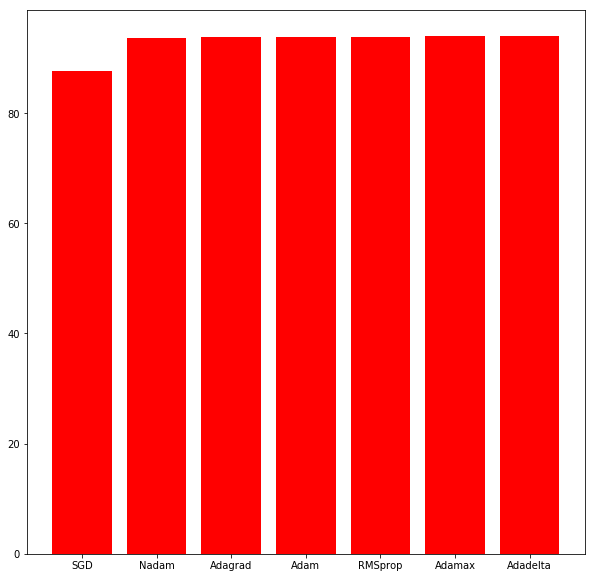

In [8]:
optimizers['SGD'] = mean(optimizers['SGD'])
optimizers['RMSprop'] = mean(optimizers['RMSprop'])
optimizers['Adagrad'] = mean(optimizers['Adagrad'])
optimizers['Adadelta'] = mean(optimizers['Adadelta'])
optimizers['Adamax'] = mean(optimizers['Adamax'])
optimizers['Nadam'] = mean(optimizers['Nadam'])
optimizers['Adam'] = mean(optimizers['Adam'])

optimizers_sorted = dict(sorted(optimizers.items(), key=operator.itemgetter(1)))

print(optimizers_sorted)

plt.figure(figsize=(10, 10))
plt.bar(optimizers_sorted.keys(), optimizers_sorted.values(), color='r')

## Model Creation and 10 cross validation

FOLD NUMBER:  1
Train on 12595 samples, validate on 281 samples
Epoch 1/1
 - 1s - loss: 1.2009 - accuracy: 0.6133 - val_loss: 0.6746 - val_accuracy: 0.7687
[18 18 18 ... 23 21 20]
[18 18 20 ... 23 21 20]


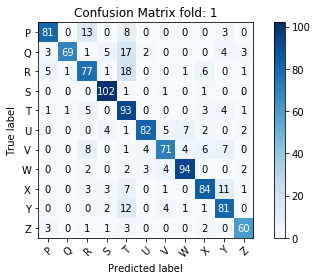

accuracy: 79.54%

FOLD NUMBER:  2
Train on 12596 samples, validate on 281 samples
Epoch 1/1
 - 1s - loss: 1.1672 - accuracy: 0.6236 - val_loss: 0.8060 - val_accuracy: 0.6940
[17 24 22 ... 19 25 20]
[17 22 22 ... 19 25 17]


KeyboardInterrupt: 

In [4]:
kfold = StratifiedKFold(n_splits=10, shuffle=True)
cvscores = []
matrix = [None]*10
report = [None]*10
history_cross = [None]*10

precision = [0]*10
recall = [0]*10
f_score_avg = [0]*10

real_prediction = list()

labels_predict = []
labels_real = []
predict = []
fold = 0

es = EarlyStopping(monitor='val_accuracy', patience = 10, verbose = 2, restore_best_weights = True)

for train, test in kfold.split(x_train, y_train):
        
    print("FOLD NUMBER: ", fold + 1)

    model = define_model('Adadelta', x_train.shape[1])
    
    x_test_real, x_val, y_test_real, y_val = train_test_split(x_train[test], y_train_oneHot[test], test_size = 0.2)

    history_cross[fold] = model.fit(x_train[train],
                                    y_train_oneHot[train],
                                    epochs=200,
                                    batch_size=256,
                                    verbose = 2,
                                    validation_data=(x_val, y_val), 
                                    callbacks = [es])

    scores = model.evaluate(x_test_real, y_test_real, verbose = 0)
    labels_predict = model.predict_classes(x_test_real)

    for predict in labels_predict:
        real_prediction.append(predict + 16)
    
    for label in y_test_real:    
        labels_real.append(np.where(label == np.amax(label))[0][0] + 16)
    

    real_prediction_array = np.array(real_prediction)
    labels_real_array = np.array(labels_real)
    
    report[fold] = classification_report(labels_real, real_prediction_array)
    
    precision[fold], recall[fold], f_score_avg[fold] = get_performance(labels_real, real_prediction_array)
    
    real_prediction.clear()
    labels_real.clear()
    
    fold += 1
    
    print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))
    cvscores.append(scores[1] * 100)
    print("")
print("%.2f%% (+/- %.2f%%)" % (np.mean(cvscores), np.std(cvscores)))
print("")

### Print performance for each class and loss/accuracy for each fold

              precision    recall  f1-score   support

          16       0.91      0.91      0.91       106
          17       0.94      0.94      0.94       100
          18       0.90      0.92      0.91       111
          19       1.00      0.98      0.99       109
          20       0.96      0.93      0.95       105
          21       0.93      0.93      0.93       106
          22       0.92      0.92      0.92       101
          23       0.97      0.97      0.97       106
          24       0.94      0.93      0.94       106
          25       0.87      0.93      0.90        97
          26       0.96      0.93      0.95        74

   micro avg       0.94      0.94      0.94      1121
   macro avg       0.94      0.94      0.94      1121
weighted avg       0.94      0.94      0.94      1121


PRECISION MEAN FOR CLASS P:  0.952
RECALL MEAN FOR CLASS P:  0.95

PRECISION MEAN FOR CLASS Q:  0.912
RECALL MEAN FOR CLASS Q:  0.931

PRECISION MEAN FOR CLASS R:  0.926
RECALL MEAN FOR 

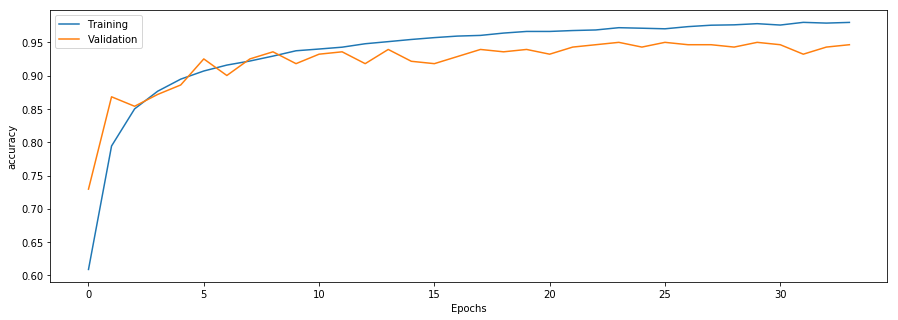

FOLD NUMBER:  2


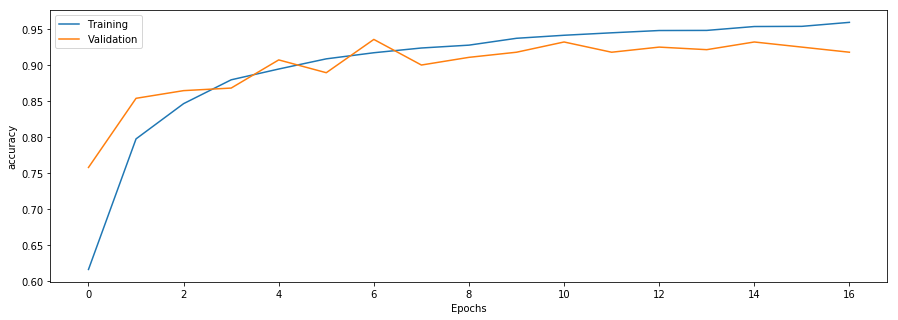

FOLD NUMBER:  3


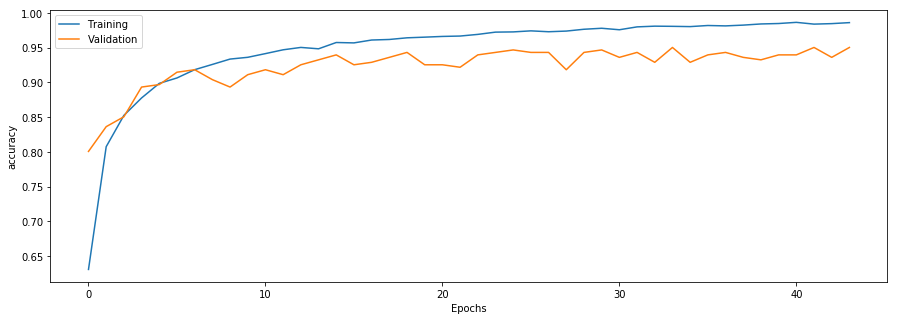

FOLD NUMBER:  4


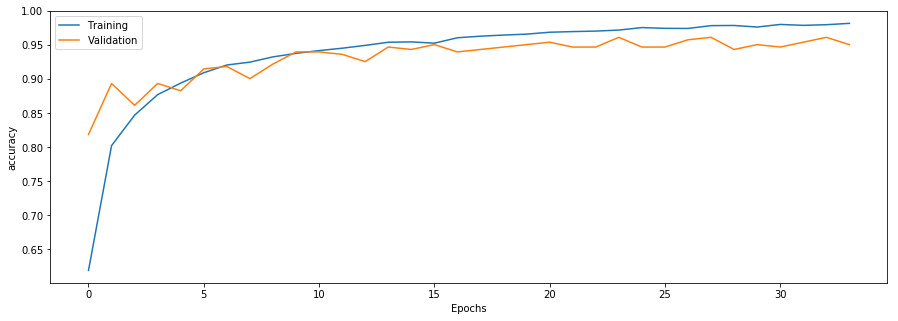

FOLD NUMBER:  5


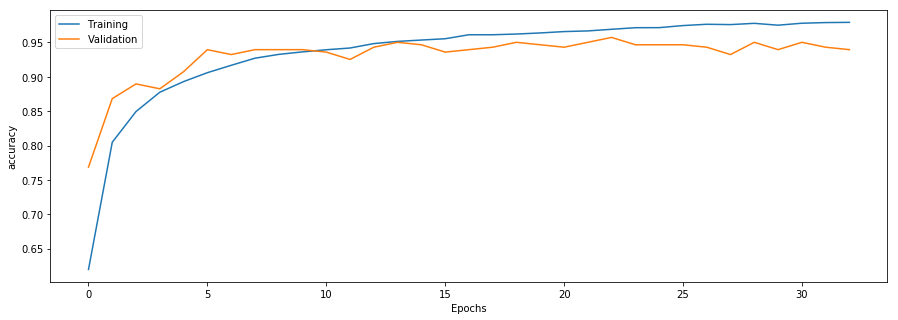

FOLD NUMBER:  6


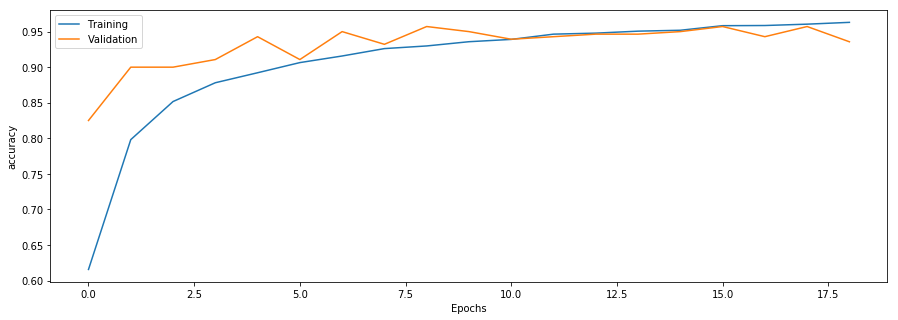

FOLD NUMBER:  7


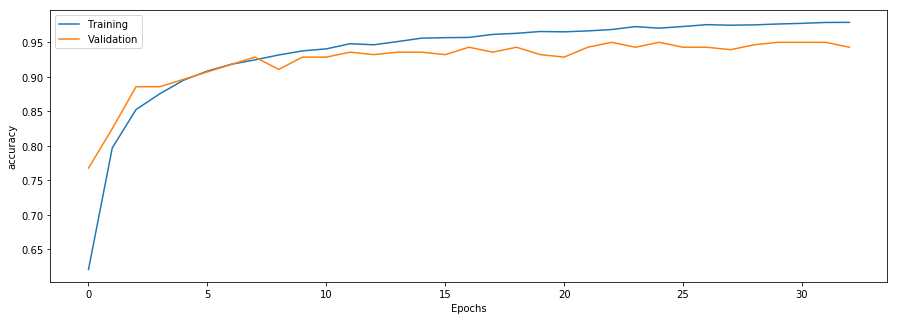

FOLD NUMBER:  8


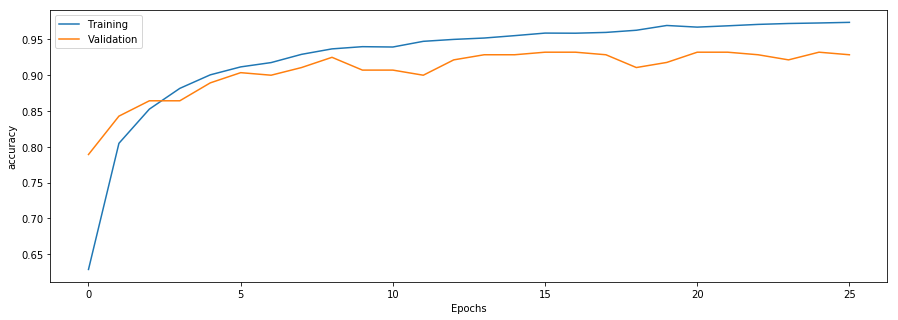

FOLD NUMBER:  9


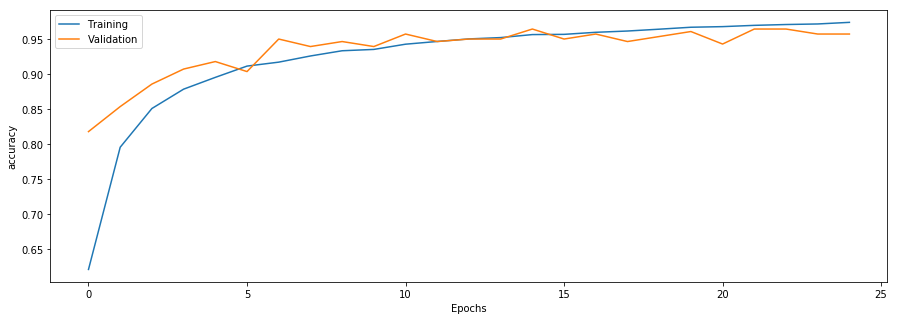

FOLD NUMBER:  10


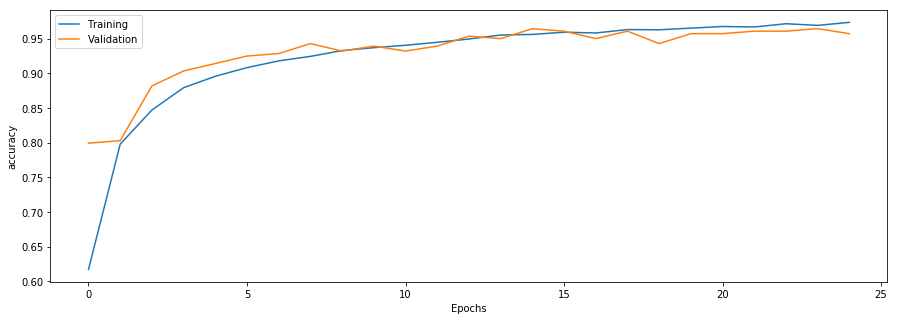

LOSS FOR EACH FOLD
FOLD NUMBER:  1


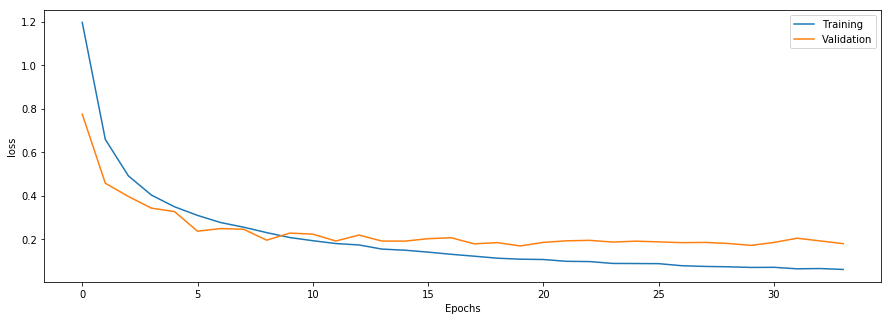

FOLD NUMBER:  2


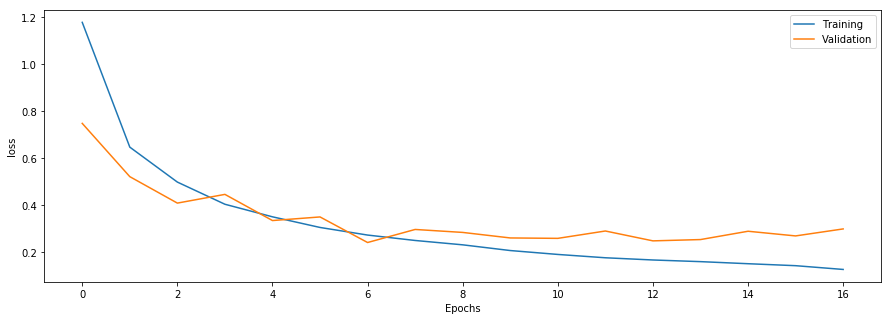

FOLD NUMBER:  3


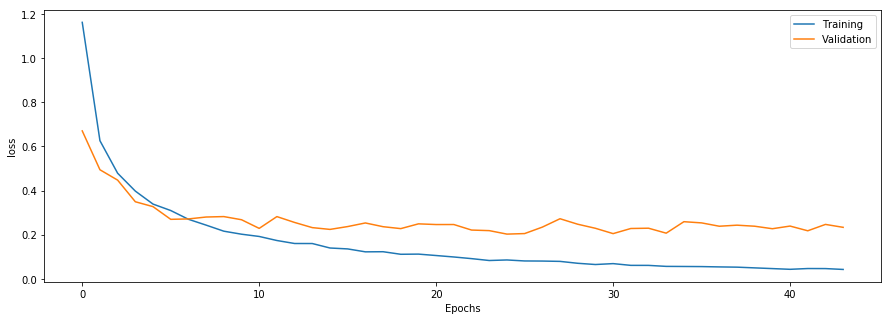

FOLD NUMBER:  4


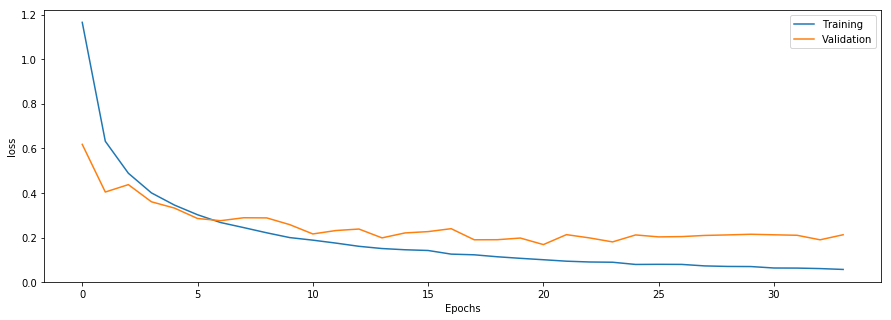

FOLD NUMBER:  5


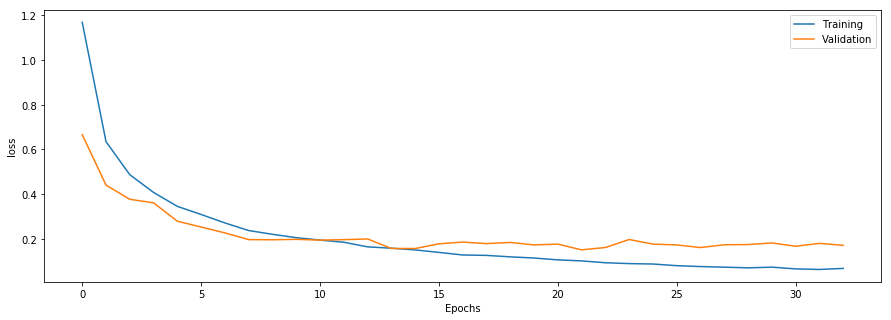

FOLD NUMBER:  6


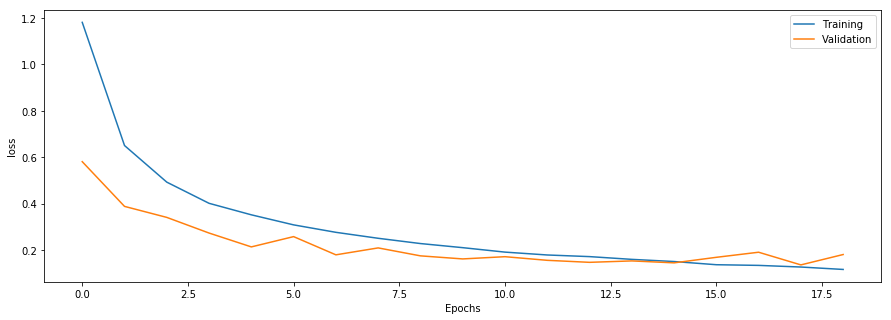

FOLD NUMBER:  7


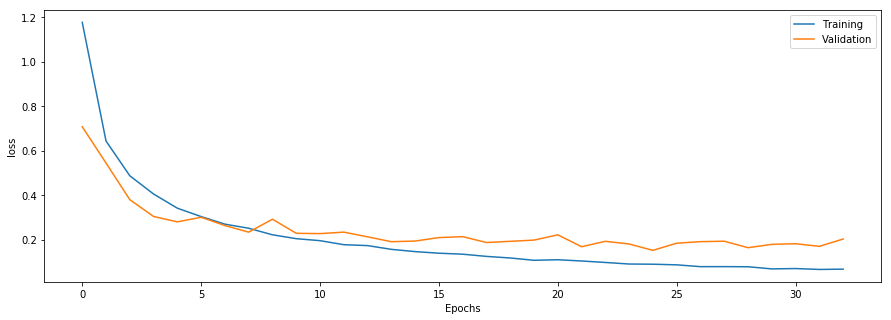

FOLD NUMBER:  8


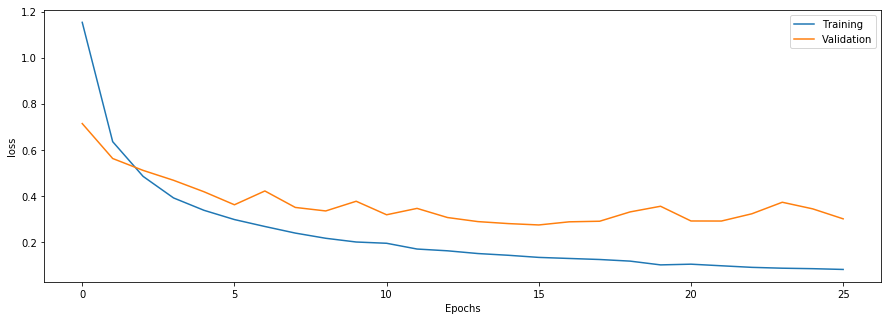

FOLD NUMBER:  9


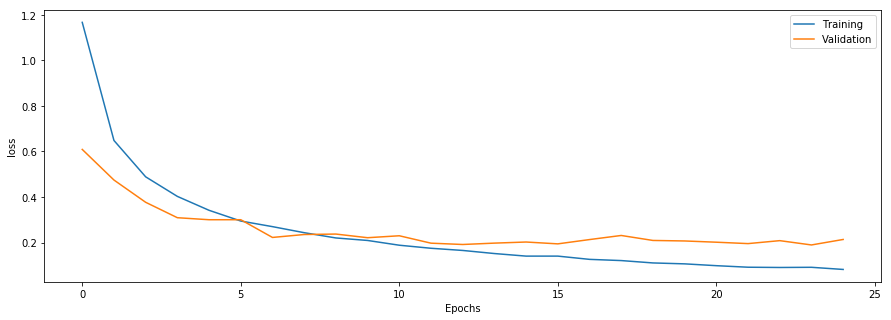

FOLD NUMBER:  10


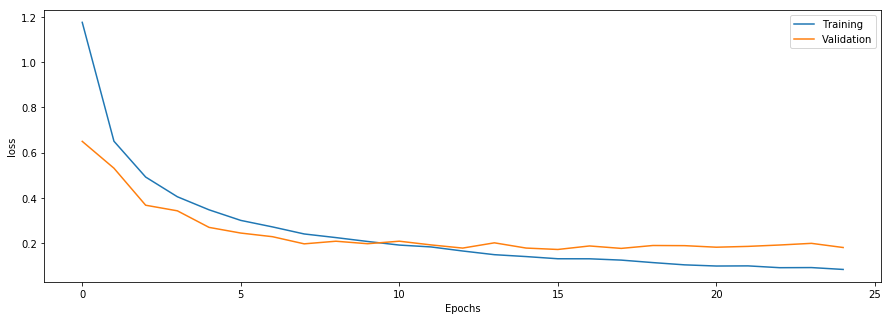

In [50]:
print(report[3])
print("")

print_class_performance(precision, recall)

print("F1 AVG SCORE MEAN FOR FOLD: ", round(mean(f_score_avg), 3))
print("")

print("ACCURACY FOR EACH FOLD")
for fold in history_cross:
    print("FOLD NUMBER: ", history_cross.index(fold) + 1)
    plot_history(fold, 'accuracy')

print("")
print("LOSS FOR EACH FOLD")
for fold in history_cross:
    print("FOLD NUMBER: ", history_cross.index(fold) + 1)
    plot_history(fold, 'loss')

## Final Model

In [24]:
es = EarlyStopping(monitor='accuracy', patience = 10, verbose = 2, restore_best_weights = True)
final_model = define_model('Adadelta', x_train.shape[1])
history = final_model.fit(x_train, y_train_oneHot, epochs=20, batch_size=256, verbose=2, callbacks = [es])

Epoch 1/20
 - 1s - loss: 1.1549 - accuracy: 0.6300
Epoch 2/20
 - 1s - loss: 0.6213 - accuracy: 0.8096
Epoch 3/20
 - 1s - loss: 0.4670 - accuracy: 0.8577
Epoch 4/20
 - 1s - loss: 0.3814 - accuracy: 0.8846
Epoch 5/20
 - 1s - loss: 0.3311 - accuracy: 0.9016
Epoch 6/20
 - 1s - loss: 0.2861 - accuracy: 0.9166
Epoch 7/20
 - 1s - loss: 0.2631 - accuracy: 0.9195
Epoch 8/20
 - 1s - loss: 0.2345 - accuracy: 0.9289
Epoch 9/20
 - 1s - loss: 0.2191 - accuracy: 0.9329
Epoch 10/20
 - 1s - loss: 0.1966 - accuracy: 0.9418
Epoch 11/20
 - 1s - loss: 0.1864 - accuracy: 0.9434
Epoch 12/20
 - 1s - loss: 0.1746 - accuracy: 0.9469
Epoch 13/20
 - 1s - loss: 0.1578 - accuracy: 0.9503
Epoch 14/20
 - 1s - loss: 0.1507 - accuracy: 0.9509
Epoch 15/20
 - 1s - loss: 0.1401 - accuracy: 0.9556
Epoch 16/20
 - 1s - loss: 0.1367 - accuracy: 0.9573
Epoch 17/20
 - 1s - loss: 0.1253 - accuracy: 0.9606
Epoch 18/20
 - 1s - loss: 0.1187 - accuracy: 0.9611
Epoch 19/20
 - 1s - loss: 0.1116 - accuracy: 0.9644
Epoch 20/20
 - 1s - l

## Show model capabilities

In [40]:
model_truncated = Sequential()
model_truncated.add(Dense(512, activation='relu', input_shape=(x_train.shape[1],)))
model_truncated.add(Dropout(0.2, noise_shape=None, seed=None))
model_truncated.add(Dense(256, activation='relu'))
model_truncated.add(Dropout(0.2, noise_shape=None, seed=None))

for i, layer in enumerate(model_truncated.layers):
    layer.set_weights(final_model.layers[i].get_weights())
    
model_truncated.compile(loss='categorical_crossentropy', optimizer='Adadelta', metrics=['accuracy'])                                                                                   

In [42]:
hidden_features = model_truncated.predict(x_train)
tsne = TSNE(n_components=2)
X_tsne = tsne.fit_transform(hidden_features[:4000]) 

In [43]:
y_train_list = list()

for outcome in y_train:
    y_train_list.append(numbers_to_character(outcome))

colors_map = np.asarray(y_train_list)

In [1]:
colors = np.array([x for x in 'b-g-r-c-m-y-k-purple-coral-lime-orange'.split('-')])
colors_map = colors_map[:4000]
plt.figure(figsize=(15,15))
cl = 0
cont = 0
for i in(('P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z')):
    indices = np.where(colors_map == i)
    plt.scatter(X_tsne[indices,0], X_tsne[indices, 1], c = colors[cl], label = i)
    cl += 1
plt.legend()
plt.show()

NameError: name 'np' is not defined

## Predict

In [202]:
test_imgs = encoder.predict(x_test) 

In [37]:
labels_predict = final_model.predict_classes(x_test)
print(labels_predict.shape)
cont = 0
    
result = open('./Giacomo_Villa_807462_score2.txt', 'w') 
for predict in labels_predict:
    result.write(str(predict + 16))
    result.write("\n")   
    cont += 1
    

(8800,)


'n = 10\nplt.figure(figsize=(28, 28))\nfor i in range(0, n):\n    ax = plt.subplot(2, m, i + 1)\n    ax.set_title("PRED: %s" %str(numbers_to_character(labels_predict[i] + 16)))\n    plt.imshow(x_test[i].reshape(28, 28))\n    plt.gray()'